In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import os
os.listdir('../data')

['bike_sharing',
 'creditcard.csv',
 'credit_cards.xls',
 'diabetes.csv',
 'HAR',
 'house_price_adv',
 'Online Retail.xlsx',
 'santander_cs',
 'sub',
 'titanic']

# Data Description
- InvoiceNo : 주문번호 'C'로 싲가하는 것은 취소 주문
- StockCode : 제품 코드
- Description : 제품 설명
- Quantity : 주문 건수
- InvoiceDate : 주문 일자
- UnitPrice : 제품 단가
- custoemrID : 고객 번호
- Country : 국가명

In [3]:
retail = pd.read_excel('../data/Online Retail.xlsx')
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


# Data Preprocessing
- Quantity > 0
- UnitPrice > 0
- CustomerID not null
- Country only UK

In [9]:
retail = retail[(retail.Quantity>0) & (retail.UnitPrice>0) & (retail.CustomerID.notnull())]
retail.shape

(397884, 8)

In [10]:
retail.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [13]:
retail.Country.value_counts()[:5]

United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: Country, dtype: int64

In [15]:
retail = retail[retail.Country == 'United Kingdom']
retail.shape

(354321, 8)

## based RFM
- Recency : 가장 최근 상품 구입 일에서 오늘까지의 기간
- Frequency : 상품 구매 횟수
- Monetary value : 총 구매 금액

In [16]:
retail['sale_amount'] = retail['Quantity'] * retail['UnitPrice']
retail['CustomerID'] = retail['CustomerID'].astype(int)

C:\Users\wjssm\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\wjssm\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
#주문 건수 많은 순
retail.CustomerID.value_counts().head()

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64

In [19]:
#sale_amount 구매 금액 많은 순
retail.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending = False)[:5]

CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64

In [21]:
#InvoiceNo, StockCode로 합쳐서 key로 쓰면, 거의 대부분 unique 하ㅣ다.
retail.groupby(['InvoiceNo','StockCode'])['InvoiceNo'].count().mean()

1.028702077315023

In [34]:
#R : 가장 최근 구매일자, F : count . M : sale_amount의 sum
agg = {
    'InvoiceDate' : 'max',
    'InvoiceNo' : 'count',
    'sale_amount' : 'sum'
}

cust_df = retail.groupby('CustomerID').agg(agg)
cust_df.head()

,InvoiceDate,InvoiceNo,sale_amount
CustomerID,,,
12346,2011-01-18 10:01:00,1,77183.60
12747,2011-12-07 14:34:00,103,4196.01
12748,2011-12-09 12:20:00,4595,33719.73
12749,2011-12-06 09:56:00,199,4090.88
12820,2011-12-06 15:12:00,59,942.34


In [35]:
cust_df = cust_df.rename(columns = {'InvoiceDate' : 'Recency',
                                   'InvoiceNo' : 'Frequency',
                                   'sale_amount' : 'Monetary'})

cust_df.reset_index(inplace = True)
cust_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73
3,12749,2011-12-06 09:56:00,199,4090.88
4,12820,2011-12-06 15:12:00,59,942.34


In [36]:
cust_df.Recency.max()

Timestamp('2011-12-09 12:49:00')

In [37]:
import datetime as dt

#오늘 기준 날짜를 2011-12-10으로
cust_df['Recency'] = dt.datetime(2011,12,10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x : x.days +1)
cust_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73
3,12749,4,199,4090.88
4,12820,4,59,942.34


# Customer Segmentation based RFM

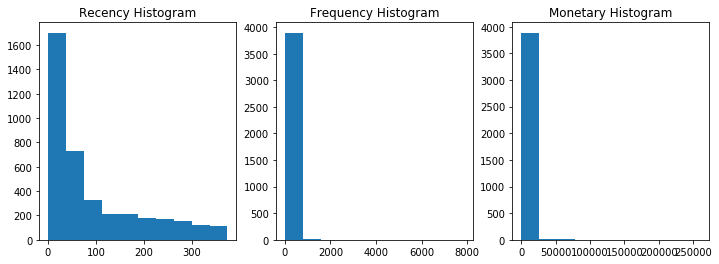

In [39]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize = (12,4), nrows = 1, ncols = 3)

ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

plt.show()

In [41]:
cust_df[['Recency','Frequency','Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


엄청 편중된 데이터

In [46]:
import matplotlib.cm as cm

def visualize_silhouette(cluster_lists, X_features) :
    
    #클러스터링할 군집의 개수를 리스트로 받아서, 각 개숫별로 클러스터링을 하고, 실루엣 계수를 구함
    n_cols = len(cluster_lists)
    
    fig, axs = plt.subplots(figsize = (4*n_cols, 4), nrows = 1, ncols = n_cols)
    
    for ind, n_cluster in enumerate(cluster_lists) :
        
        clusterer = KMeans(n_clusters = n_cluster, max_iter = 500, random_state = 0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : ' + str(n_cluster) + '\n' \
                          'Silhouette Score : ' + str(round(sil_avg,3)))
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

## K-means

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_df[['Recency','Frequency','Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

In [45]:
kmeans = KMeans(n_clusters = 3, random_state=0)
cust_df['cluster_label'] = kmeans.fit_predict(X_features_scaled)

print('Silhouette Score : {0:.3f}'.format(silhouette_score(X_features_scaled, cust_df['cluster_label'])))

Silhouette Score : 0.592


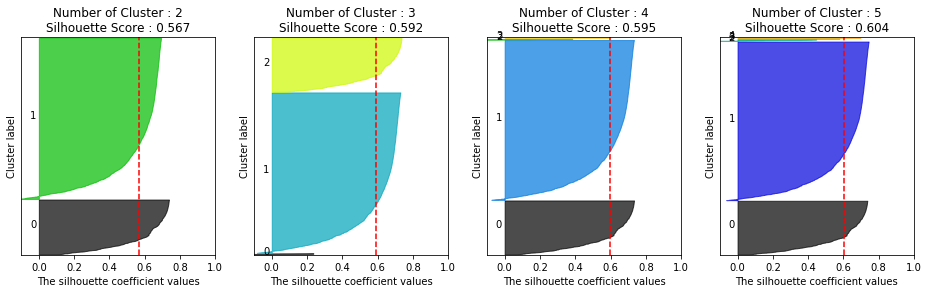

In [47]:
visualize_silhouette([2,3,4,5], X_features_scaled)

2개는 너무 개괄적
개수가 점점 늘어날수록 군집에 속하는 개수가 줄어듬

## log-transformation

In [48]:
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

X_features = cust_df[['Recency_log','Frequency_log','Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

In [49]:
cust_df['cluster_label']  = kmeans.fit_predict(X_features_scaled)

print('Silhouette Score : {0:.3f}'.format(silhouette_score(X_features_scaled, cust_df['cluster_label'])))

Silhouette Score : 0.305


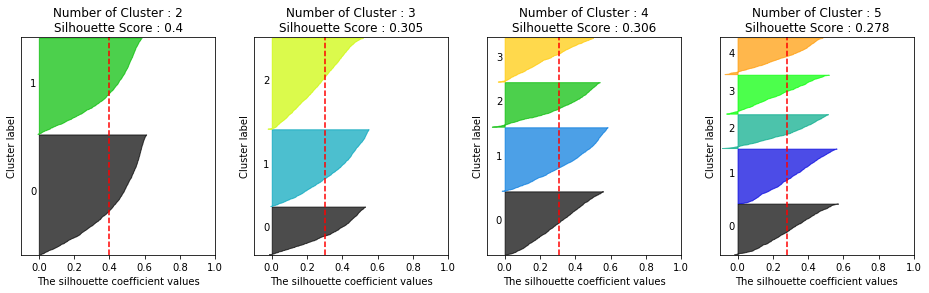

In [50]:
visualize_silhouette([2,3,4,5], X_features_scaled)